# Training Neural Networks

The network we built in the previous part is dumb, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

## Backpropagation

For single layer networks, gradient descent is simple to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks, although it's straightforward once you learn about it. 

This is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/w1_backprop_graph.png' width=400px>

In the forward pass through the network, our data and operations go from right to left here. To train the weights with gradient descent, we propagate the gradient of the cost backwards through the network. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{\partial \ell}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial C}{\partial l_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
w^\prime = w - \alpha \frac{\partial \ell}{\partial w}
$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

## Autograd

Torch provides a module, `autograd`, for automatically calculating the gradient of tensors. It does this by keeping track of operations performed on tensors. For PyTorch to track operations, you need to wrap a tensor with the `Variable` class from `torch.autograd`. You can get the tensor back with the `.data` attribute of the Variable.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

import helper

In [ ]:
x = torch.randn(2,2)
x = Variable(x, requires_grad=True)
print(x)

In [ ]:
y = x**2
print(y)

Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [ ]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autgrad module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [ ]:
z = y.mean()
print(z)

You can check the gradients for `x` and `y` but they are empty currently.

In [ ]:
print(x.grad)

To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [ ]:
z.backward()
print(x.grad)
print(x/2)

These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the cost, then, go backwards to calculate the gradients with respect to the cost. Once we have the gradients we can make a gradient descent step. 

## Training the network!

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

In [ ]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 200, 50, 10 units each
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 50)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(50, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
    
    def predict(self, x):
        ''' This function for predicts classes by calculating the softmax '''
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

In [ ]:
net = Network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

First, let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes.

In [ ]:
print('Initial weights - ', net.fc1.weight)

dataiter = iter(trainloader)
images, labels = dataiter.next()

images.resize_(64, 784)

# Create Variables for the inputs and targets
inputs = Variable(images)
targets = Variable(labels)

# Clear the gradients from all Variables
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = net.forward(inputs)
loss = criterion(output, targets)
loss.backward()
print('Gradient -', net.fc1.weight.grad)
optimizer.step()

In [ ]:
print('Updated weights - ', net.fc1.weight)

### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. This is fairly straightforward. We'll loop through the mini-batches in our dataset, pass the data through the network to calculate the losses, get the gradients, then run the optimizer.

In [ ]:
net = Network()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 20
for e in range(epochs):
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        # Wrap images and labels in Variables so we can calculate gradients
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        
        output = net.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(testloader):
                
                images = images.resize_(images.size()[0], 784)
                inputs = Variable(images, volatile=True)
                
                predicted = net.predict(inputs).data
                equality = (labels == predicted.max(1)[1])
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Test accuracy: {:.4f}".format(accuracy/(ii+1)))
            running_loss = 0

In [85]:
dataiter = iter(testloader)
images, labels = dataiter.next()

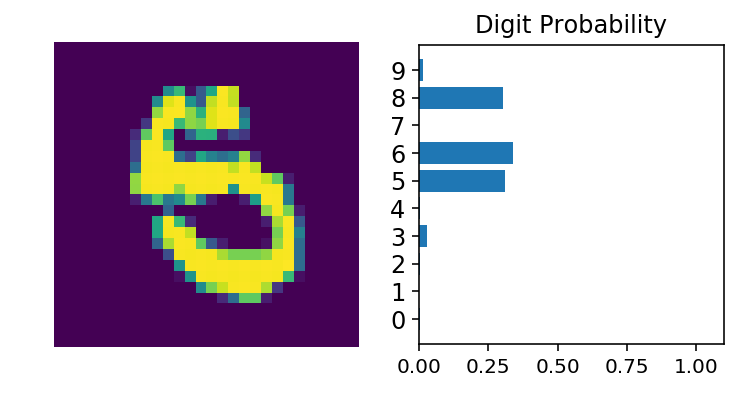

In [86]:
img = images[0]
ps = net.predict(Variable(img.resize_(1, 784)))
helper.view_classify(img.resize_(1, 28, 28), ps)

Now our network isn't so dumb. It can accurately predict the digits in our images. Next up you'll write the code for training a neural network on a more complex dataset.